In [1]:
import os
 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
import albumentations as A
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

## Train loop class

In [ ]:
import torch
import torchvision
from tqdm import tqdm


class TrainFasterRCNN:

    def __init__(self, model: torchvision, trainDataloader: torch, valDataloader: torch, optimizer: torch,
                 scheduler: torch = None, device: str = 'cuda:0', model_name: str = 'FasterRCNN_v1',
                 iouThreshold: float = 0.5):

        self.model = model
        self.trainDataloader = trainDataloader
        self.valDataloader = valDataloader
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.model_name = model_name
        self.iouThreshold = iouThreshold

        self.model.to(self.device)

    def _train(self):
        print('Training')
        train_loss_list = []

        # initialize tqdm progress bar
        prog_bar = tqdm(self.trainDataloader, total=len(self.trainDataloader))

        for i, data in enumerate(prog_bar):
            self.optimizer.zero_grad()

            images, targets = data

            images = list(image.to(self.device) for image in images)
            targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]

            loss_dict = self.model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            train_loss_list.append(loss_value)

            losses.backward()
            self.optimizer.step()
            if self.scheduler is not None:
                self.scheduler.step()

            # update the loss value beside the progress bar for each iteration
            prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")

        train_loss = sum(train_loss_list) / (i + 1)

        return train_loss

    @torch.no_grad()
    def _evolution(self):
        print('Validating')

        val_loss_list = []
        # initialize tqdm progress bar
        prog_bar = tqdm(self.valDataloader, total=len(self.valDataloader))

        for i, data in enumerate(prog_bar):
            images, targets = data

            images = list(image.to(self.device) for image in images)
            targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]

            loss_dict = self.model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            val_loss_list.append(loss_value)

            prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")

        val_loss = sum(val_loss_list) / (i + 1)

        return val_loss

    def train_net(self, num_epochs):

        train_loss_history, val_loss_history = [], []

        for epoch in range(num_epochs):
            print(f"\nEPOCH {epoch + 1} of {num_epochs}")

            train_loss = self._train()
            val_loss = self._evolution()

            train_loss_history.append(train_loss)
            val_loss_history.append(val_loss)

            if epoch == 0:
                best_loss = val_loss

            if (val_loss <= best_loss) and (epoch != 0):
                best_loss = val_loss
                try:
                    torch.save(self.model, f'./weights/{self.model_name}_best.pth')
                    print('Save best model.')
                except:
                    print("Can't save best model!")

            try:
                torch.save(self.model, f'./weights/{self.model_name}_last.pth')
            except:
                print("Can't save last model!")

        return {
            'train_loss_history': train_loss_history,
            'val_loss_history': val_loss_history
        }

## Dataset class

In [ ]:
import json
import os

import albumentations as A
import cv2 as cv
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torchvision import transforms
from torch.utils.data import Dataset


class CarDatasets(Dataset):
    path_images = './data/vkcv2022-contest-02-carplates/data'

    def __init__(self, name_json: str = 'train.json', train_size: float = 0.9,
                 type_dataset: str = 'train', width: int = 640, height: int = 640, transform: A = None):

        with open(os.path.join(self.path_images, name_json)) as js_file:
            data = json.load(js_file)

        if type_dataset == 'train':
            self.all_data, _ = train_test_split(data, train_size=train_size, random_state=17)
        elif type_dataset == 'val':
            _, self.all_data = train_test_split(data, train_size=train_size, random_state=17)
        else:
            print("Неверный тип датасета! М.б. 'train' / 'val'")

        self.width = width
        self.height = height
        self.transform = transform

    def __len__(self):
        return len(self.all_data)

    def __getitem__(self, idx):
        annot_data = self.all_data[idx]

        try:
            image = cv.cvtColor(
                cv.imread(os.path.join(self.path_images, annot_data['file'])),
                cv.COLOR_BGR2RGB
            ).astype(np.float32)
        except Exception:
            idx = 0
            annot_data = self.all_data[idx]
            image = cv.cvtColor(
                cv.imread(os.path.join(self.path_images, annot_data['file'])),
                cv.COLOR_BGR2RGB
            ).astype(np.float32)
            print("Can't open image!")

        image_resized = cv.resize(image, (self.width, self.height))
        image_resized /= 255.0

        image_width = image.shape[1]
        image_height = image.shape[0]

        annotation = annot_data['nums']

        boxes = []

        for box in annotation:
            boxes.append(
                [
                    (min([box[0] for box in box['box']])/image_width)*self.width,
                    (min([box[1] for box in box['box']])/image_height)*self.height,
                    (max([box[0] for box in box['box']])/image_width)*self.width,
                    (max([box[1] for box in box['box']])/image_height)*self.height
                ]
            )

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(np.ones(shape=(boxes.shape[0]), dtype=np.int64), dtype=torch.int64)

        if self.transform is not None:
            try:
                sample = self.transform(image=image_resized, bboxes=boxes, labels=labels)
                image_resized = sample['image']
                boxes = torch.Tensor(sample['bboxes'])
            except Exception:
                print("Can't transform!")

        image_resized = transforms.ToTensor()(image_resized)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx])
        }

        return image_resized, target


def collate_fn(batch):
    return tuple(zip(*batch))

## Train model

In [3]:
BATCH_SIZE = 32
NUM_WORKERS = 16

RESIZE_TO_WIDTH = 640
RESIZE_TO_HEIGHT = 640
CLASSES = ['background', 'Plate']
NUM_CLASSES = 2 # ['.']
 
DEVICE = 'cuda:0'
NUM_EPOCHS = 20
LR = 5e-4

In [4]:
TrainTransform = A.Compose(
    [
        A.Blur(blur_limit=3, p=0.1),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05, p=0.25)
    ],
    bbox_params={
                'format': 'pascal_voc',
                'label_fields': ['labels']
                }
)

trainDataset = CarDatasets(type_dataset='train', width=RESIZE_TO_WIDTH, height=RESIZE_TO_HEIGHT, transform=TrainTransform)
valDataset = CarDatasets(type_dataset='val', width=RESIZE_TO_WIDTH, height=RESIZE_TO_HEIGHT)

In [5]:
len(trainDataset), len(valDataset)

(23069, 2564)

In [6]:
trainDataset[1]

(tensor([[[0.2143, 0.1716, 0.1389,  ..., 0.4866, 0.4986, 0.4762],
          [0.2590, 0.1882, 0.1298,  ..., 0.4883, 0.4546, 0.4777],
          [0.2536, 0.2008, 0.1555,  ..., 0.4790, 0.4778, 0.4688],
          ...,
          [0.0819, 0.1427, 0.0840,  ..., 0.2099, 0.2365, 0.2522],
          [0.1002, 0.1220, 0.0911,  ..., 0.2177, 0.2575, 0.2518],
          [0.1051, 0.1189, 0.1636,  ..., 0.2402, 0.2672, 0.2826]],
 
         [[0.2370, 0.2053, 0.1854,  ..., 0.4641, 0.4633, 0.4485],
          [0.2684, 0.1983, 0.1384,  ..., 0.4657, 0.4174, 0.4467],
          [0.2636, 0.2004, 0.1449,  ..., 0.4564, 0.4421, 0.4374],
          ...,
          [0.1624, 0.1673, 0.1672,  ..., 0.2609, 0.2763, 0.2662],
          [0.1767, 0.1792, 0.1420,  ..., 0.2578, 0.2793, 0.2544],
          [0.1765, 0.1947, 0.1827,  ..., 0.2601, 0.2702, 0.2664]],
 
         [[0.2145, 0.1254, 0.1320,  ..., 0.3871, 0.4044, 0.3672],
          [0.2449, 0.1473, 0.1137,  ..., 0.3881, 0.3649, 0.3790],
          [0.2467, 0.1760, 0.1437,  ...,

In [7]:
trainDataloader = DataLoader(
    trainDataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)
valDataloader = DataLoader(
    valDataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn
)

In [8]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES) 

/home/asemenov/FasterRCNN/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/asemenov/FasterRCNN/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [10]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

backbone.body.conv1.weight False
backbone.body.layer1.0.conv1.weight False
backbone.body.layer1.0.conv2.weight False
backbone.body.layer1.0.conv3.weight False
backbone.body.layer1.0.downsample.0.weight False
backbone.body.layer1.1.conv1.weight False
backbone.body.layer1.1.conv2.weight False
backbone.body.layer1.1.conv3.weight False
backbone.body.layer1.2.conv1.weight False
backbone.body.layer1.2.conv2.weight False
backbone.body.layer1.2.conv3.weight False
backbone.body.layer2.0.conv1.weight True
backbone.body.layer2.0.conv2.weight True
backbone.body.layer2.0.conv3.weight True
backbone.body.layer2.0.downsample.0.weight True
backbone.body.layer2.1.conv1.weight True
backbone.body.layer2.1.conv2.weight True
backbone.body.layer2.1.conv3.weight True
backbone.body.layer2.2.conv1.weight True
backbone.body.layer2.2.conv2.weight True
backbone.body.layer2.2.conv3.weight True
backbone.body.layer2.3.conv1.weight True
backbone.body.layer2.3.conv2.weight True
backbone.body.layer2.3.conv3.weight True


In [11]:
for param in model.backbone.body.parameters():
    param.requires_grad = False

for param in model.backbone.body.layer3.parameters():
    param.requires_grad = True    
    
for param in model.backbone.body.layer4.parameters():
    param.requires_grad = True
    
for name, param in model.named_parameters():
    print(name, param.requires_grad)

backbone.body.conv1.weight False
backbone.body.layer1.0.conv1.weight False
backbone.body.layer1.0.conv2.weight False
backbone.body.layer1.0.conv3.weight False
backbone.body.layer1.0.downsample.0.weight False
backbone.body.layer1.1.conv1.weight False
backbone.body.layer1.1.conv2.weight False
backbone.body.layer1.1.conv3.weight False
backbone.body.layer1.2.conv1.weight False
backbone.body.layer1.2.conv2.weight False
backbone.body.layer1.2.conv3.weight False
backbone.body.layer2.0.conv1.weight False
backbone.body.layer2.0.conv2.weight False
backbone.body.layer2.0.conv3.weight False
backbone.body.layer2.0.downsample.0.weight False
backbone.body.layer2.1.conv1.weight False
backbone.body.layer2.1.conv2.weight False
backbone.body.layer2.1.conv3.weight False
backbone.body.layer2.2.conv1.weight False
backbone.body.layer2.2.conv2.weight False
backbone.body.layer2.2.conv3.weight False
backbone.body.layer2.3.conv1.weight False
backbone.body.layer2.3.conv2.weight False
backbone.body.layer2.3.conv3.

In [12]:
optimizer = AdamW(model.parameters(), lr=LR)
scheduler = OneCycleLR(
    optimizer=optimizer, 
    max_lr=LR, 
    steps_per_epoch=len(trainDataloader), 
    epochs=NUM_EPOCHS, 
    pct_start=0.1, 
    anneal_strategy='cos'
)

In [13]:
trainer = TrainFasterRCNN(
    model=model, 
    trainDataloader=trainDataloader, 
    valDataloader=valDataloader, 
    optimizer=optimizer,
    scheduler=scheduler, 
    device=DEVICE, 
    model_name='FasterRCNN_v1',
    iouThreshold=0.5
)

results = trainer.train_net(num_epochs=NUM_EPOCHS)


EPOCH 1 of 20
Training


Loss: 0.2634:   2%|█▏                                                                  | 12/721 [00:25<22:14,  1.88s/it]

Can't transform!


Loss: 0.0494:  87%|██████████████████████████████████████████████████████████         | 625/721 [19:33<02:59,  1.87s/it]

Can't open image!


Loss: 0.0413: 100%|███████████████████████████████████████████████████████████████████| 721/721 [22:33<00:00,  1.88s/it]


Validating


Loss: 0.0692: 100%|█████████████████████████████████████████████████████████████████████| 81/81 [01:29<00:00,  1.10s/it]



EPOCH 2 of 20
Training


Loss: 0.0388:  64%|██████████████████████████████████████████▊                        | 461/721 [14:26<08:05,  1.87s/it]

Can't open image!


Loss: 0.0417:  68%|█████████████████████████████████████████████▌                     | 490/721 [15:21<07:11,  1.87s/it]

Can't transform!


Loss: 0.0294: 100%|███████████████████████████████████████████████████████████████████| 721/721 [22:30<00:00,  1.87s/it]


Validating


Loss: 0.0601: 100%|█████████████████████████████████████████████████████████████████████| 81/81 [01:29<00:00,  1.10s/it]


Save best model.

EPOCH 3 of 20
Training


Loss: 0.0383:  32%|█████████████████████▋                                             | 233/721 [07:14<15:25,  1.90s/it]

Can't transform!


Loss: 0.0474:  33%|█████████████████████▉                                             | 236/721 [07:19<15:19,  1.90s/it]

Can't open image!


Loss: 0.0484: 100%|███████████████████████████████████████████████████████████████████| 721/721 [22:22<00:00,  1.86s/it]


Validating


Loss: 0.0749: 100%|█████████████████████████████████████████████████████████████████████| 81/81 [01:28<00:00,  1.10s/it]



EPOCH 4 of 20
Training


Loss: 0.0424:  23%|███████████████▌                                                   | 167/721 [05:12<17:06,  1.85s/it]

Can't transform!


Loss: 0.0423:  75%|█████████████████████████████████████████████████▉                 | 538/721 [16:43<05:46,  1.89s/it]

Can't open image!


Loss: 0.0466: 100%|███████████████████████████████████████████████████████████████████| 721/721 [22:24<00:00,  1.87s/it]


Validating


Loss: 0.0500: 100%|█████████████████████████████████████████████████████████████████████| 81/81 [01:28<00:00,  1.09s/it]



EPOCH 5 of 20
Training


Loss: 0.0266:  70%|██████████████████████████████████████████████▊                    | 504/721 [15:42<06:44,  1.87s/it]

Can't open image!


Loss: 0.0270:  79%|█████████████████████████████████████████████████████▏             | 572/721 [17:49<04:36,  1.86s/it]

Can't transform!


Loss: 0.0303: 100%|███████████████████████████████████████████████████████████████████| 721/721 [22:27<00:00,  1.87s/it]


Validating


Loss: 0.0528: 100%|█████████████████████████████████████████████████████████████████████| 81/81 [01:28<00:00,  1.10s/it]



EPOCH 6 of 20
Training


Loss: 0.0228:  47%|███████████████████████████████▋                                   | 341/721 [10:36<11:45,  1.86s/it]

Can't open image!


Loss: 0.0370:  83%|███████████████████████████████████████████████████████▌           | 598/721 [18:34<03:48,  1.86s/it]

Can't transform!


Loss: 0.0266: 100%|███████████████████████████████████████████████████████████████████| 721/721 [22:23<00:00,  1.86s/it]


Validating


Loss: 0.0497: 100%|█████████████████████████████████████████████████████████████████████| 81/81 [01:29<00:00,  1.10s/it]


Save best model.

EPOCH 7 of 20
Training


Loss: 0.0315:  13%|█████████                                                           | 96/721 [02:59<19:19,  1.86s/it]

Can't open image!


Loss: 0.0234:  57%|██████████████████████████████████████▎                            | 412/721 [12:43<09:32,  1.85s/it]

Can't transform!


Loss: 0.0213: 100%|███████████████████████████████████████████████████████████████████| 721/721 [22:20<00:00,  1.86s/it]


Validating


Loss: 0.0392: 100%|█████████████████████████████████████████████████████████████████████| 81/81 [01:29<00:00,  1.10s/it]



EPOCH 8 of 20
Training



  0%|                                                                                           | 0/721 [00:00<?, ?it/s]

Can't open image!


Loss: 0.0266:  86%|█████████████████████████████████████████████████████████▌         | 620/721 [19:23<03:09,  1.88s/it]

Can't transform!


Loss: 0.0260: 100%|███████████████████████████████████████████████████████████████████| 721/721 [22:32<00:00,  1.88s/it]


Validating


Loss: 0.0403: 100%|█████████████████████████████████████████████████████████████████████| 81/81 [01:28<00:00,  1.09s/it]


Save best model.

EPOCH 9 of 20
Training


Loss: 0.0198:   2%|█▌                                                                  | 17/721 [00:34<21:44,  1.85s/it]

Can't open image!


Loss: 0.0273:  78%|███████████████████████████████████████████████████▉               | 559/721 [17:19<04:58,  1.84s/it]

Can't transform!


Loss: 0.0256: 100%|███████████████████████████████████████████████████████████████████| 721/721 [22:18<00:00,  1.86s/it]


Validating


Loss: 0.0537: 100%|█████████████████████████████████████████████████████████████████████| 81/81 [01:28<00:00,  1.10s/it]



EPOCH 10 of 20
Training


Loss: 0.0257:  16%|██████████▊                                                        | 117/721 [03:37<18:28,  1.84s/it]

Can't transform!


Loss: 0.0231:  91%|████████████████████████████████████████████████████████████▊      | 654/721 [20:07<02:03,  1.84s/it]

Can't open image!


Loss: 0.0186: 100%|███████████████████████████████████████████████████████████████████| 721/721 [22:11<00:00,  1.85s/it]


Validating


Loss: 0.0398: 100%|█████████████████████████████████████████████████████████████████████| 81/81 [01:28<00:00,  1.10s/it]



EPOCH 11 of 20
Training


Loss: 0.0181:  42%|███████████████████████████▉                                       | 300/721 [09:16<13:01,  1.86s/it]

Can't open image!


Loss: 0.0261:  66%|███████████████████████████████████████████▉                       | 473/721 [14:35<07:36,  1.84s/it]

Can't transform!


Loss: 0.0167: 100%|███████████████████████████████████████████████████████████████████| 721/721 [22:12<00:00,  1.85s/it]


Validating


Loss: 0.0515: 100%|█████████████████████████████████████████████████████████████████████| 81/81 [01:28<00:00,  1.09s/it]



EPOCH 12 of 20
Training


Loss: 0.0175:  52%|██████████████████████████████████▊                                | 375/721 [11:33<10:39,  1.85s/it]

Can't open image!


Loss: 0.0238:  69%|█████████████████████████████████████████████▉                     | 494/721 [15:13<06:58,  1.84s/it]

Can't transform!


Loss: 0.0298: 100%|███████████████████████████████████████████████████████████████████| 721/721 [22:12<00:00,  1.85s/it]


Validating


Loss: 0.0411: 100%|█████████████████████████████████████████████████████████████████████| 81/81 [01:28<00:00,  1.09s/it]



EPOCH 13 of 20
Training


Loss: 0.0233:   6%|████                                                                | 43/721 [01:21<20:46,  1.84s/it]

Can't transform!


Loss: 0.0221:  33%|██████████████████████▏                                            | 239/721 [07:23<15:06,  1.88s/it]

Can't open image!


Loss: 0.0254: 100%|███████████████████████████████████████████████████████████████████| 721/721 [22:11<00:00,  1.85s/it]


Validating


Loss: 0.0417: 100%|█████████████████████████████████████████████████████████████████████| 81/81 [01:28<00:00,  1.10s/it]



EPOCH 14 of 20
Training


Loss: 0.0157:  54%|███████████████████████████████████▊                               | 386/721 [11:54<10:16,  1.84s/it]

Can't open image!


Loss: 0.0120:  64%|██████████████████████████████████████████▋                        | 459/721 [14:08<08:05,  1.85s/it]

Can't transform!


Loss: 0.0171: 100%|███████████████████████████████████████████████████████████████████| 721/721 [22:11<00:00,  1.85s/it]


Validating


Loss: 0.0343: 100%|█████████████████████████████████████████████████████████████████████| 81/81 [01:28<00:00,  1.09s/it]



EPOCH 15 of 20
Training


Loss: 0.0129:  41%|███████████████████████████▌                                       | 296/721 [09:06<12:59,  1.83s/it]

Can't transform!


Loss: 0.0092:  76%|██████████████████████████████████████████████████▊                | 547/721 [16:48<05:20,  1.84s/it]

Can't open image!


Loss: 0.0093: 100%|███████████████████████████████████████████████████████████████████| 721/721 [22:09<00:00,  1.84s/it]


Validating


Loss: 0.0332: 100%|█████████████████████████████████████████████████████████████████████| 81/81 [01:28<00:00,  1.09s/it]



EPOCH 16 of 20
Training


Loss: 0.0073:  31%|█████████████████████                                              | 226/721 [06:58<15:09,  1.84s/it]

Can't open image!


Loss: 0.0079:  72%|████████████████████████████████████████████████▏                  | 519/721 [15:58<06:12,  1.84s/it]

Can't transform!


Loss: 0.0113: 100%|███████████████████████████████████████████████████████████████████| 721/721 [22:10<00:00,  1.84s/it]


Validating


Loss: 0.0393: 100%|█████████████████████████████████████████████████████████████████████| 81/81 [01:28<00:00,  1.09s/it]



EPOCH 17 of 20
Training


Loss: 0.0075:  16%|██████████▉                                                        | 118/721 [03:39<18:41,  1.86s/it]

Can't open image!


Loss: 0.0071:  39%|█████████████████████████▊                                         | 278/721 [08:33<13:33,  1.84s/it]

Can't transform!


Loss: 0.0083: 100%|███████████████████████████████████████████████████████████████████| 721/721 [22:09<00:00,  1.84s/it]


Validating


Loss: 0.0480: 100%|█████████████████████████████████████████████████████████████████████| 81/81 [01:28<00:00,  1.09s/it]



EPOCH 18 of 20
Training


Loss: 0.0079:  22%|██████████████▊                                                    | 159/721 [04:55<17:16,  1.84s/it]

Can't open image!


Loss: 0.0078:  71%|███████████████████████████████████████████████▊                   | 515/721 [15:50<06:20,  1.85s/it]

Can't transform!


Loss: 0.0068: 100%|███████████████████████████████████████████████████████████████████| 721/721 [22:09<00:00,  1.84s/it]


Validating


Loss: 0.0439: 100%|█████████████████████████████████████████████████████████████████████| 81/81 [01:28<00:00,  1.09s/it]



EPOCH 19 of 20
Training


Loss: 0.0061:  46%|██████████████████████████████▉                                    | 333/721 [10:14<11:52,  1.84s/it]

Can't transform!


Loss: 0.0053:  69%|██████████████████████████████████████████████▌                    | 501/721 [15:23<06:43,  1.84s/it]

Can't open image!


Loss: 0.0049: 100%|███████████████████████████████████████████████████████████████████| 721/721 [22:08<00:00,  1.84s/it]


Validating


Loss: 0.0374: 100%|█████████████████████████████████████████████████████████████████████| 81/81 [01:28<00:00,  1.09s/it]



EPOCH 20 of 20
Training


Loss: 0.0043:   2%|█▎                                                                  | 14/721 [00:28<21:39,  1.84s/it]

Can't open image!


Loss: 0.0045:  92%|█████████████████████████████████████████████████████████████▉     | 666/721 [20:28<01:41,  1.84s/it]

Can't transform!


Loss: 0.0048: 100%|███████████████████████████████████████████████████████████████████| 721/721 [22:09<00:00,  1.84s/it]


Validating


Loss: 0.0343: 100%|█████████████████████████████████████████████████████████████████████| 81/81 [01:28<00:00,  1.09s/it]


## Calc metrics

In [16]:
import torch
from tqdm import tqdm

In [18]:
from metrics.BoundingBox import BoundingBox
from metrics.BoundingBoxes import BoundingBoxes
from metrics.Evaluator import *
from metrics.utils import BBFormat

In [75]:
model = torch.load('./weights/FasterRCNN_v1_best.pth')
model.eval()
model.to('cuda:0')
valDataset = CarDatasets(type_dataset='val', width=RESIZE_TO_WIDTH, height=RESIZE_TO_HEIGHT)

In [76]:
allBoundingBoxes = BoundingBoxes()

bbFormat = BBFormat.XYX2Y2

for index, plate in enumerate(tqdm(valDataset)):
    bbx = np.array(plate[1]['boxes'])
    for bb in bbx: 
        x1, y1, x2, y2 = bb[0], bb[1], bb[2], bb[3]

        bb = BoundingBox(f'{index}',
                         0,
                         x1,
                         y1,
                         x2,
                         y2,
                         CoordinatesType.Absolute,
                         (0, 0),
                         BBType.GroundTruth,
                         format=bbFormat)
        allBoundingBoxes.addBoundingBox(bb)


    with torch.no_grad():
        predict = model([plate[0].to('cuda:0')])

    boxes = list()
    confidence = list()
    for value in predict:
        if len(value['boxes'].cpu().detach().numpy()) > 0:
            boxes.append(value['boxes'].cpu().detach().numpy()[0])
            confidence.append(value['scores'].cpu().detach().numpy()[0])


    for idx, bbox in enumerate(boxes):
        bb = BoundingBox(f'{index}',
                        0,
                        bbox[0],
                        bbox[1],
                        bbox[2],
                        bbox[3],
                        CoordinatesType.Absolute,
                        (0, 0),
                        BBType.Detected,
                        confidence[idx],
                        format=bbFormat)
        allBoundingBoxes.addBoundingBox(bb)

100%|███████████████████████████████████████████████████████████████████████████████| 2564/2564 [02:38<00:00, 16.14it/s]


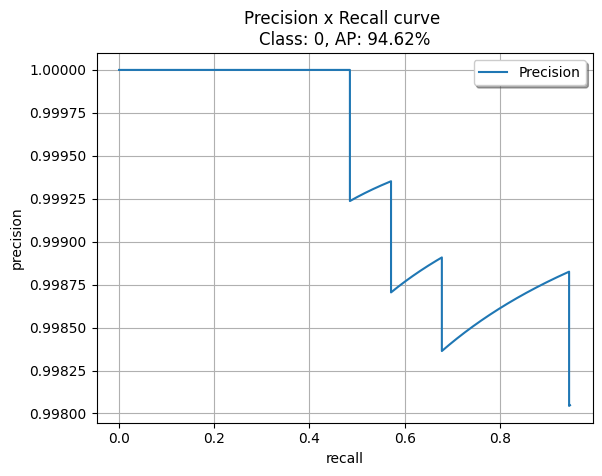

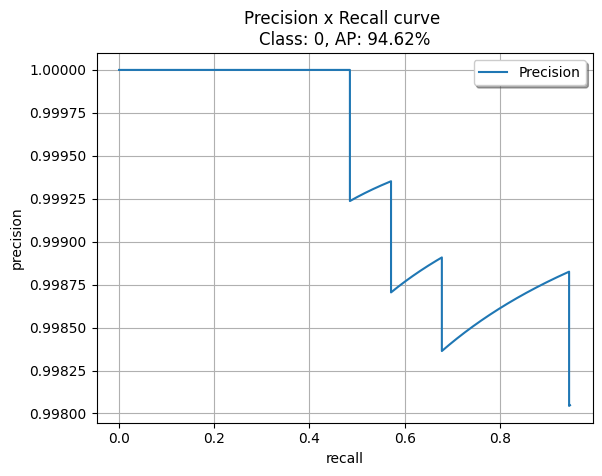

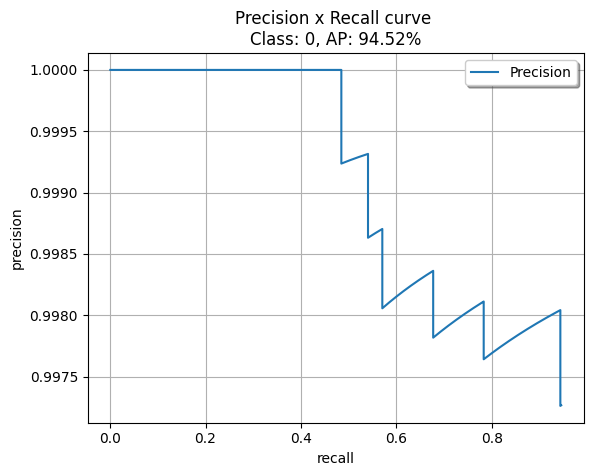

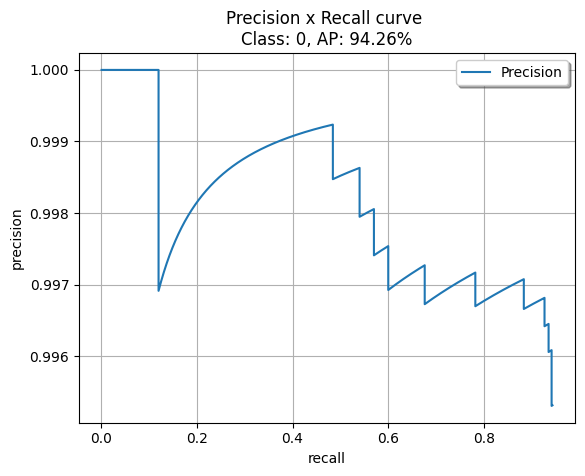

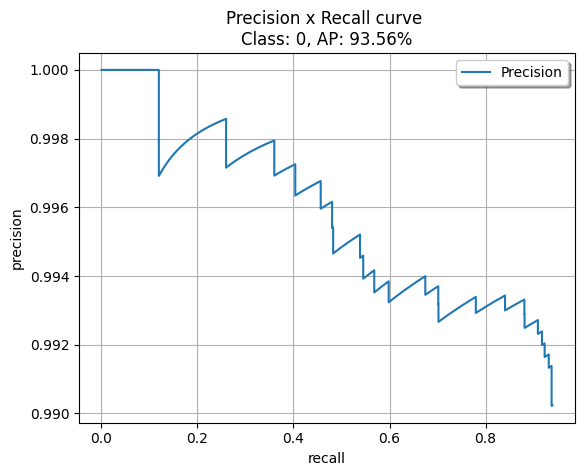

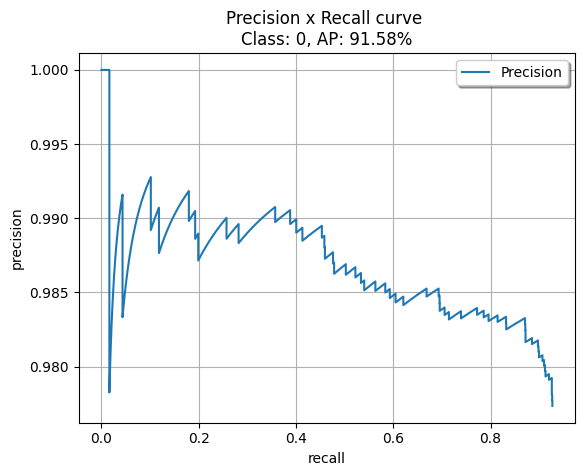

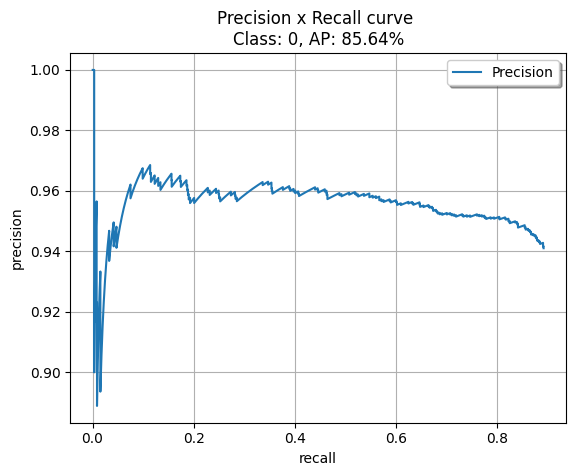

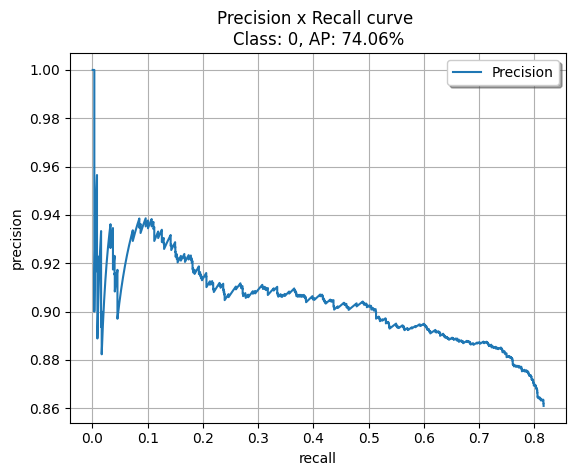

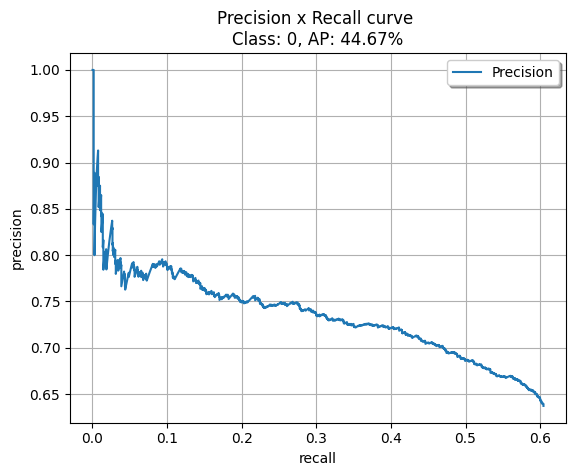

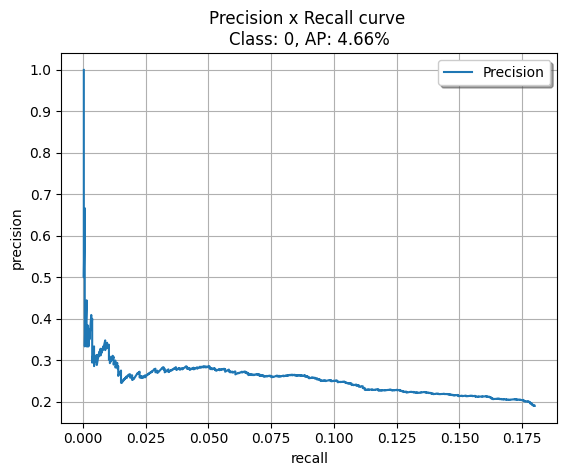

Map@0.5: 0.9461770060586482
Map@0.5-0.95: 0.7721818145985437


In [79]:
savePath = './'
iouThreshold = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
map_result = []

for iou in iouThreshold:
    evaluator = Evaluator()
    acc_AP = 0
    validClasses = 0

    # Plot Precision x Recall curve
    detections = evaluator.PlotPrecisionRecallCurve(
        allBoundingBoxes,  # Object containing all bounding boxes (ground truths and detections)
        IOUThreshold=iou,  # IOU threshold
        method=MethodAveragePrecision.EveryPointInterpolation,
        showAP=True,  # Show Average Precision in the title of the plot
        showInterpolatedPrecision=False,  # Don't plot the interpolated precision curve
        savePath=savePath,
        showGraphic=True)

    for metricsPerClass in detections:
        # Get metric values per each class
        cl = metricsPerClass['class']
        ap = metricsPerClass['AP']
        precision = metricsPerClass['precision']
        recall = metricsPerClass['recall']
        totalPositives = metricsPerClass['total positives']
        total_TP = metricsPerClass['total TP']
        total_FP = metricsPerClass['total FP']

        if totalPositives > 0:
            validClasses = validClasses + 1
            acc_AP = acc_AP + ap
            prec = ['%.2f' % p for p in precision]
            rec = ['%.2f' % r for r in recall]
            ap_str = "{0:.2f}%".format(ap * 100)
            
    mAP = acc_AP / validClasses
    map_result.append(mAP)

print(f'Map@0.5: {map_result[0]}')
print(f'Map@0.5-0.95: {sum(map_result) / len(map_result)}')

In [80]:
model = torch.load('./weights/FasterRCNN_v1_last.pth')
model.eval()
model.to('cuda:0')
valDataset = CarDatasets(type_dataset='val', width=RESIZE_TO_WIDTH, height=RESIZE_TO_HEIGHT)

In [81]:
allBoundingBoxes = BoundingBoxes()

bbFormat = BBFormat.XYX2Y2

for index, plate in enumerate(tqdm(valDataset)):
    bbx = np.array(plate[1]['boxes'])
    for bb in bbx: 
        x1, y1, x2, y2 = bb[0], bb[1], bb[2], bb[3]

        bb = BoundingBox(f'{index}',
                         0,
                         x1,
                         y1,
                         x2,
                         y2,
                         CoordinatesType.Absolute,
                         (0, 0),
                         BBType.GroundTruth,
                         format=bbFormat)
        allBoundingBoxes.addBoundingBox(bb)


    with torch.no_grad():
        predict = model([plate[0].to('cuda:0')])

    boxes = list()
    confidence = list()
    for value in predict:
        if len(value['boxes'].cpu().detach().numpy()) > 0:
            boxes.append(value['boxes'].cpu().detach().numpy()[0])
            confidence.append(value['scores'].cpu().detach().numpy()[0])


    for idx, bbox in enumerate(boxes):
        bb = BoundingBox(f'{index}',
                        0,
                        bbox[0],
                        bbox[1],
                        bbox[2],
                        bbox[3],
                        CoordinatesType.Absolute,
                        (0, 0),
                        BBType.Detected,
                        confidence[idx],
                        format=bbFormat)
        allBoundingBoxes.addBoundingBox(bb)

100%|███████████████████████████████████████████████████████████████████████████████| 2564/2564 [02:37<00:00, 16.25it/s]


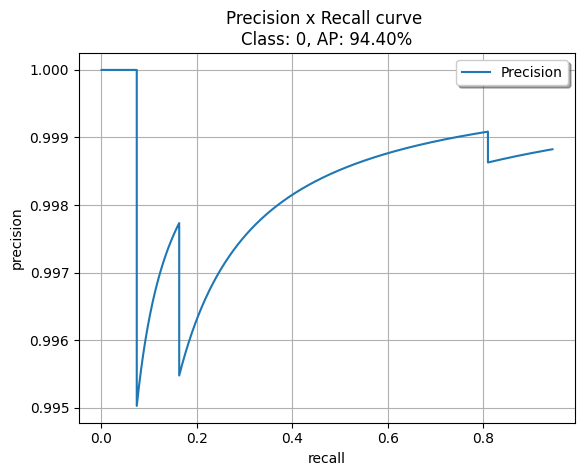

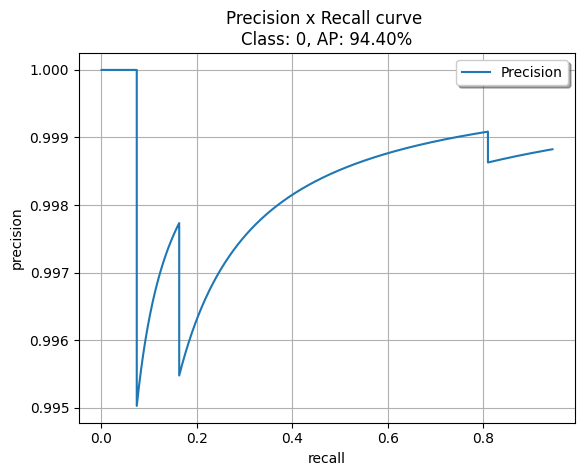

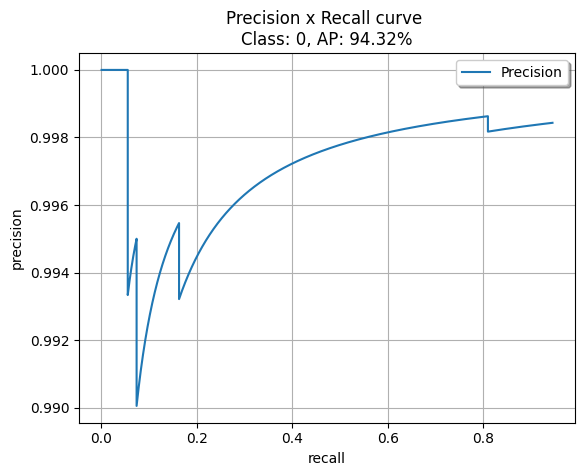

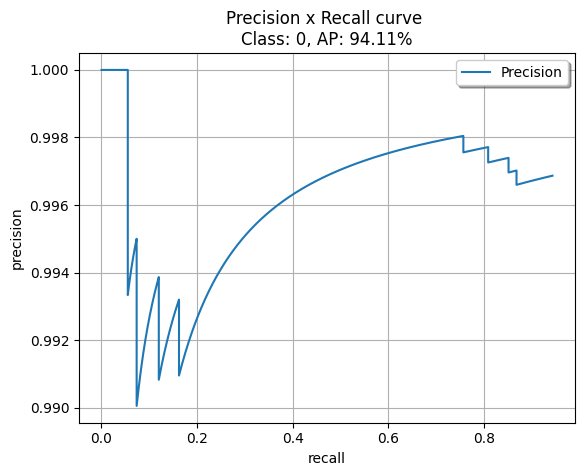

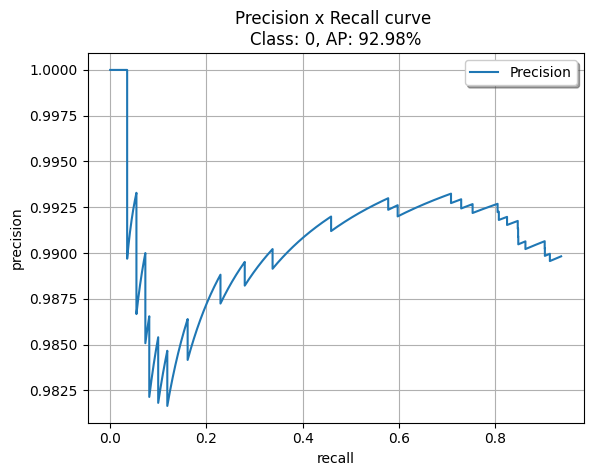

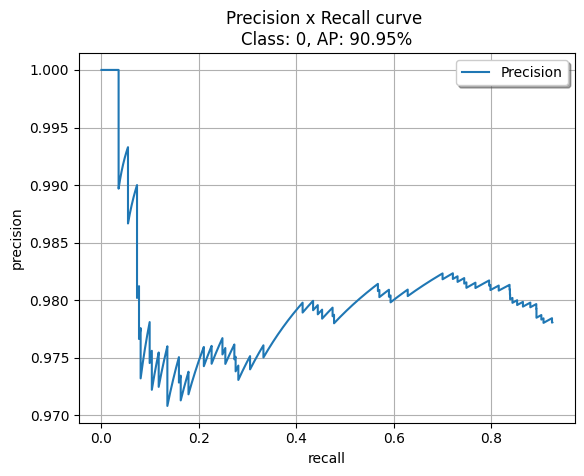

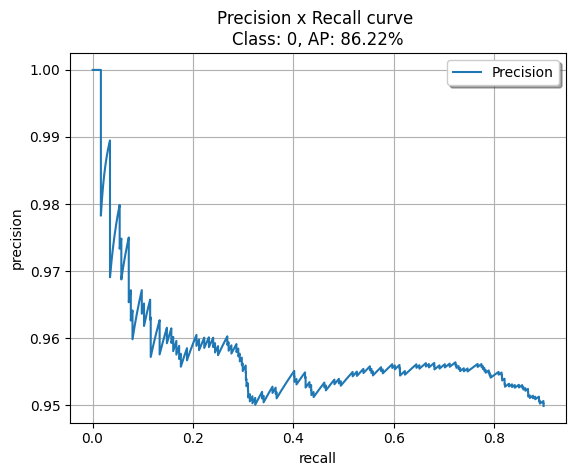

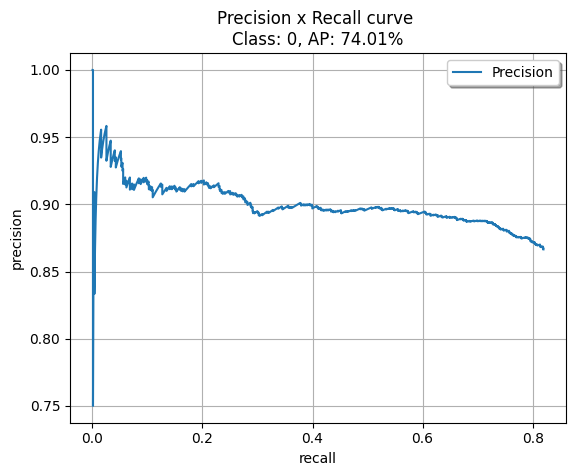

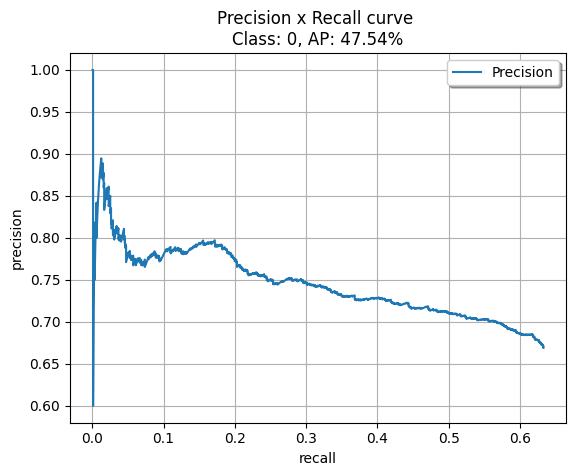

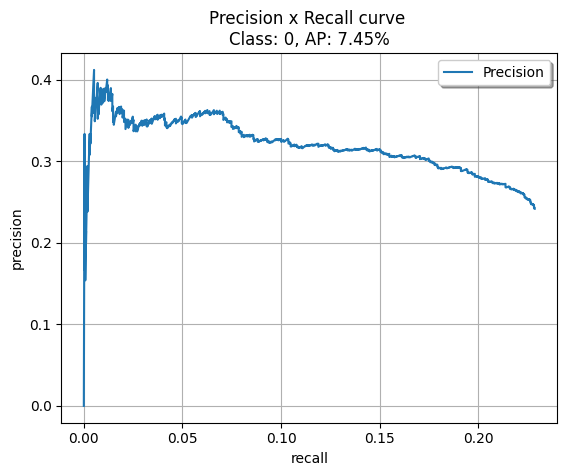

Map@0.5: 0.943983668250895
Map@0.5-0.95: 0.7763818009782141


In [82]:
savePath = './'
iouThreshold = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
map_result = []

for iou in iouThreshold:
    evaluator = Evaluator()
    acc_AP = 0
    validClasses = 0

    # Plot Precision x Recall curve
    detections = evaluator.PlotPrecisionRecallCurve(
        allBoundingBoxes,  # Object containing all bounding boxes (ground truths and detections)
        IOUThreshold=iou,  # IOU threshold
        method=MethodAveragePrecision.EveryPointInterpolation,
        showAP=True,  # Show Average Precision in the title of the plot
        showInterpolatedPrecision=False,  # Don't plot the interpolated precision curve
        savePath=savePath,
        showGraphic=True)

    for metricsPerClass in detections:
        # Get metric values per each class
        cl = metricsPerClass['class']
        ap = metricsPerClass['AP']
        precision = metricsPerClass['precision']
        recall = metricsPerClass['recall']
        totalPositives = metricsPerClass['total positives']
        total_TP = metricsPerClass['total TP']
        total_FP = metricsPerClass['total FP']

        if totalPositives > 0:
            validClasses = validClasses + 1
            acc_AP = acc_AP + ap
            prec = ['%.2f' % p for p in precision]
            rec = ['%.2f' % r for r in recall]
            ap_str = "{0:.2f}%".format(ap * 100)
            
    mAP = acc_AP / validClasses
    map_result.append(mAP)

print(f'Map@0.5: {map_result[0]}')
print(f'Map@0.5-0.95: {sum(map_result) / len(map_result)}')

**Best model**
- mAP@0.5: 0.9461770060586482
- mAP@0.5-0.95: 0.7721818145985437

**Last model**
- mAP@0.5: 0.943983668250895
- mAP@0.5-0.95: 0.7763818009782141

В силу результатов берем в итоговый inference: **Last model**
